In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using BenchmarkTools

using SciPy
using Statistics

using PyPlot

In [2]:
function HR!(du, u, p, t)
    
    function sigma(x)
            return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
    end
    
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du[1] = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du[2] = c - d * x1 ^2 - y1
    du[3] = r * ( s * ( x1 - xr ) - z1 )
    
    du[4] = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du[5] = c - d * x2 ^2 - y2
    du[6] = r * ( s * ( x2 - xr ) - z2 )
    
    return SVector(du[1], du[2], du[3],
                    du[4], du[5], du[6])
end

HR! (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [20]:
u0 = [ 0., 0.2, 0.3,
        0., 0.5, 0.6]
tspan = (0., 100000.)

a = 1.
b = 3.
c = 1.
d = 5.
xr = -1.6
r = 0.01 # 0.01
s = 5.
I = 4.
xv = 2.

k1= -0.17
k2 = k1

-0.17

In [21]:
k_space = range(0., 1., step = 0.001)


spectrum_array = zeros(3, length(k_space))

int(x) = floor(Int, x)
length(k_space)

1001

In [22]:
for (i, k) in enumerate(k_space)
    if i == 1
        global initialcondition =  [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
        # [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
        # [-0.9160076813527358, -3.865225136766191, 3.268578478929024, -1.1205357248388321, -5.850291104803018, 3.3389018145276816]
    end
    println("Initial condition: $initialcondition"); flush(stdout)
    println("k: $k"); flush(stdout)
    
    p = [a, b, c, d,
        s, xr, r, I, xv, k1, k2, k]
    prob = ODEProblem(HR!, initialcondition, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR!, initialcondition, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:3, i] = spectrum[1:3]
    
    println("Spectrum: ", spectrum_array[1:3, i]); flush(stdout)
    
    initialcondition = sol[length(sol.u)]
    
    println("Last point: ", initialcondition); flush(stdout)
    
    x_sum = sol[1,:][50000:end] + sol[4,:][50000:end]
    
    index = signal.argrelmax( x_sum )[1]
    spikes = [x_sum[x] for x in index]
    Hs = Statistics.mean(spikes) + 6 * Statistics.std(spikes)
    
    sel_, pdf_ = CALCPDF(spikes)
    
    fig, ax = subplots(figsize = (8, 8))

    ax.set_yscale("log")

    ax.plot(sel_, pdf_, label  = "k: $k")
    ax.axvline(Hs, color ="red", linestyle ="--")
    ax.tick_params(labelsize = 25)
    ax.legend(loc="upper left", fontsize = 25)
    fig.savefig("res_HR_full_small/pdf/$i.png")
    close()
    
    fig, ax = subplots(figsize = (40, 10))

    ax.plot(x_sum[1:int(length(x_sum) / 4)], lw = 0.5, label  = "k: $k")
    ax.axhline(Hs, color ="red", linestyle ="--")
    ax.tick_params(labelsize = 25)
    ax.legend(loc="upper left", fontsize = 25)
    fig.savefig("res_HR_full_small/timeseries/$i.png") # fig.savefig("res_HR/$i timesries.png")
    close()
    
    fig, ax = subplots(3, 1, figsize = (40, 10))
    ax[1].set_yscale("log")

    ax[1].plot(sel_, pdf_, label  = "k: $k")
    ax[1].axvline(Hs, color ="red", linestyle ="--")
    ax[1].tick_params(labelsize = 15)
    ax[1].legend(loc="upper left", fontsize = 15)
    
    ax[2].plot(x_sum, lw = 0.5, label  = "k: $k") # [1:int(length(x_sum) / 2)]
    ax[2].axhline(Hs, color ="red", linestyle ="--")
    ax[2].tick_params(labelsize = 15)
    
    ax[3].scatter(k, spectrum_array[1, i], s = 40, color = "red")
    ax[3].scatter(k, spectrum_array[2, i], s = 40, color = "green")
    ax[3].scatter(k, spectrum_array[3, i], s = 40, color = "blue")
    ax[3].axhline(0, color = "black")
    ax[3].tick_params(labelsize = 15)

    fig.savefig("res_HR_full_small/full/$i.png") # fig.savefig("res_HR/$i FULL.png")
    close()
    
    println(">>>>>>>>>>>>>>>")
    println("")
    
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
k: 0.0
Spectrum: [0.014584032827825125, 0.005321692026721335, -3.217915223217033e-5]
Last point: [-1.404156523652797, -8.918510057192986, 3.7583636147011488, -0.9400592481778764, -3.3709729955082945, 4.11700058653857]
>>>>>>>>>>>>>>>

Initial condition: [-1.404156523652797, -8.918510057192986, 3.7583636147011488, -0.9400592481778764, -3.3709729955082945, 4.11700058653857]
k: 0.001
Spectrum: [0.014331171284231302, 0.005621617677813972, 3.4938517829744995e-6]
Last point: [-1.0552947779674118, -4.760273229097834, 3.7302494041842933, -0.6987353550945181, -1.9028178363821082, 3.825880699858923]
>>>>>>>>>>>>>>>

Initial condition: [-1.0552947779674118, -4.760273229097834, 3.7302494041842933, -0.6987353550945181, -1.9028178363821082, 3.825880699858923]
k: 0.002
Spectrum: [0.014889865580591393, 0.005724001025038818, -9.732159076236652e-6]
Last point: [-0.8983040301464223, -3.3981133555132095, 3.701303754817509, -1.2036217617590999, -6.0931069

>>>>>>>>>>>>>>>

Initial condition: [1.5375118521719287, -4.085554246965098, 4.158212571891608, -1.1987157033803528, -6.045155455524122, 3.5130894232749745]
k: 0.022
Spectrum: [0.014536658209291044, 0.006116903121249401, -3.5046981926604327e-5]
Last point: [-1.1654691271581796, -6.029896469315972, 3.610291557976618, -0.9203102347931148, -3.2263115017367316, 4.102419261280065]
>>>>>>>>>>>>>>>

Initial condition: [-1.1654691271581796, -6.029896469315972, 3.610291557976618, -0.9203102347931148, -3.2263115017367316, 4.102419261280065]
k: 0.023
Spectrum: [0.014821058164943177, 0.005769980995721054, 1.8407163743205198e-5]
Last point: [-0.8861075447765742, -3.0924702442674894, 3.9251788669267547, -1.409940341883322, -8.890460838210911, 3.8887349448459774]
>>>>>>>>>>>>>>>

Initial condition: [-0.8861075447765742, -3.0924702442674894, 3.9251788669267547, -1.409940341883322, -8.890460838210911, 3.8887349448459774]
k: 0.024
Spectrum: [0.014974032602174081, 0.006281207933225723, -1.331958759785066

Last point: [-1.277987950310328, -7.2125792517688865, 3.747290567248139, -0.4579819367554329, -0.6113427251059858, 3.9371940873432014]
>>>>>>>>>>>>>>>

Initial condition: [-1.277987950310328, -7.2125792517688865, 3.747290567248139, -0.4579819367554329, -0.6113427251059858, 3.9371940873432014]
k: 0.044
Spectrum: [0.015659058797382653, 0.005793964403128658, -4.159314908445776e-5]
Last point: [-0.928569351364784, -3.3551624111983887, 4.025289333688591, -0.9312166029352409, -3.8649649129270194, 3.480558998285859]
>>>>>>>>>>>>>>>

Initial condition: [-0.928569351364784, -3.3551624111983887, 4.025289333688591, -0.9312166029352409, -3.8649649129270194, 3.480558998285859]
k: 0.045
Spectrum: [0.015384279332035743, 0.006272657290737581, 5.413501979121757e-6]
Last point: [-1.1650821092981465, -5.683993348936357, 3.992186656940111, -0.774433327659071, -2.372399423758623, 3.8185120252155427]
>>>>>>>>>>>>>>>

Initial condition: [-1.1650821092981465, -5.683993348936357, 3.992186656940111, -0.77443332

k: 0.065
Spectrum: [0.015295467120677614, 0.005988749034627334, 1.7829239957633074e-5]
Last point: [-1.288416795517049, -6.678109371307189, 4.0393137602273494, 0.14027861888797036, 0.39948430374711463, 3.6127026836287905]
>>>>>>>>>>>>>>>

Initial condition: [-1.288416795517049, -6.678109371307189, 4.0393137602273494, 0.14027861888797036, 0.39948430374711463, 3.6127026836287905]
k: 0.066
Spectrum: [0.01568405036308574, 0.00593752641835665, -7.118292156652747e-6]
Last point: [-0.8861246761420664, -3.011257235766908, 4.021890970929246, -0.980650786056316, -4.331023867678017, 3.4439126330943095]
>>>>>>>>>>>>>>>

Initial condition: [-0.8861246761420664, -3.011257235766908, 4.021890970929246, -0.980650786056316, -4.331023867678017, 3.4439126330943095]
k: 0.067
Spectrum: [0.01703993766462815, 0.006253288818307762, 1.9895765669007504e-5]
Last point: [-1.2633250926428163, -6.757035139946363, 4.0801879636927545, -1.0065310628905613, -4.191922655965047, 3.8354764868961775]
>>>>>>>>>>>>>>>

Initia

>>>>>>>>>>>>>>>

Initial condition: [-1.3499690571165759, -8.240335226598138, 3.7258510488749814, -0.6894504152974169, -1.5664451654262541, 4.098686038740511]
k: 0.087
Spectrum: [0.016655289143619443, 0.0061570528009361105, 1.3897702934736857e-6]
Last point: [-0.7986185863166556, -2.8493580880753715, 3.478666813586126, -0.7965087276455659, -2.0652356954881506, 4.355541945034475]
>>>>>>>>>>>>>>>

Initial condition: [-0.7986185863166556, -2.8493580880753715, 3.478666813586126, -0.7965087276455659, -2.0652356954881506, 4.355541945034475]
k: 0.088
Spectrum: [0.017439765313088478, 0.006323403222674402, -1.7678032522931562e-5]
Last point: [-0.8771051380166439, -2.975243827898634, 3.9422972965547904, -1.4425434901446232, -9.424544534866413, 3.865412459553907]
>>>>>>>>>>>>>>>

Initial condition: [-0.8771051380166439, -2.975243827898634, 3.9422972965547904, -1.4425434901446232, -9.424544534866413, 3.865412459553907]
k: 0.089
Spectrum: [0.01748158628679075, 0.006047785224101008, -5.7679059698206

Last point: [-1.329796314685775, -7.900647292576813, 3.800701266908283, -0.8440182260685967, -2.746903064989345, 3.9139609677161618]
>>>>>>>>>>>>>>>

Initial condition: [-1.329796314685775, -7.900647292576813, 3.800701266908283, -0.8440182260685967, -2.746903064989345, 3.9139609677161618]
k: 0.109
Spectrum: [0.01724074160594823, 0.005263532342706583, -7.507549100499419e-5]
Last point: [-0.6415424559334092, -1.268288371583936, 4.177453768796744, -0.7466301048086755, -2.157240853231373, 3.8770574113425655]
>>>>>>>>>>>>>>>

Initial condition: [-0.6415424559334092, -1.268288371583936, 4.177453768796744, -0.7466301048086755, -2.157240853231373, 3.8770574113425655]
k: 0.11
Spectrum: [0.017280378784247194, 0.00574870872275612, -4.407892712745417e-5]
Last point: [-1.266462768111701, -7.213858055629665, 3.6605207581681363, -0.8092245295524225, -2.269426718706969, 4.174884967448019]
>>>>>>>>>>>>>>>

Initial condition: [-1.266462768111701, -7.213858055629665, 3.6605207581681363, -0.80922452955242

k: 0.13
Spectrum: [0.0170827273244929, 0.004430964782603777, 2.2852675631430144e-5]
Last point: [-0.9570125406529363, -3.5046121180950327, 4.147829796854416, -0.7782140570379877, -2.03304530758268, 4.230694520865952]
>>>>>>>>>>>>>>>

Initial condition: [-0.9570125406529363, -3.5046121180950327, 4.147829796854416, -0.7782140570379877, -2.03304530758268, 4.230694520865952]
k: 0.131
Spectrum: [0.017413908203551855, 0.004697410618431581, -6.782530882358303e-5]
Last point: [-0.911438952651946, -3.0937260235862833, 4.123771330592772, -0.35642549201519547, -0.34458856099325175, 3.794416137686677]
>>>>>>>>>>>>>>>

Initial condition: [-0.911438952651946, -3.0937260235862833, 4.123771330592772, -0.35642549201519547, -0.34458856099325175, 3.794416137686677]
k: 0.132
Spectrum: [0.017087648460563737, 0.00468948267268657, 8.462393102039494e-6]
Last point: [-0.8873223051482563, -3.432027229429468, 3.6031193680248683, -0.6326437913836807, -1.1614922851635756, 4.2272235313836966]
>>>>>>>>>>>>>>>

Initi

k: 0.152
Spectrum: [0.015385811184954655, 0.0028318495644702435, 1.5169223671836572e-5]
Last point: [-1.0826167593403817, -5.202563337172107, 3.5959236435043826, -0.7437845749138718, -1.8125463036979785, 4.19918476896568]
>>>>>>>>>>>>>>>

Initial condition: [-1.0826167593403817, -5.202563337172107, 3.5959236435043826, -0.7437845749138718, -1.8125463036979785, 4.19918476896568]
k: 0.153
Spectrum: [0.015637230155853773, 0.003646258310617654, -4.396193567132015e-5]
Last point: [-0.7519439197086457, -1.8412309911834897, 4.17293914103159, -1.443991219356745, -8.874025531604069, 4.528647811335516]
>>>>>>>>>>>>>>>

Initial condition: [-0.7519439197086457, -1.8412309911834897, 4.17293914103159, -1.443991219356745, -8.874025531604069, 4.528647811335516]
k: 0.154
Spectrum: [0.0166502656886418, 0.0029004277697185364, -4.4127507419238e-5]
Last point: [-0.6925302979542225, -2.2083565485726155, 3.4251812063410423, -0.49710798909310244, -0.24112901660181446, 4.585643148476261]
>>>>>>>>>>>>>>>

Initia

>>>>>>>>>>>>>>>

Initial condition: [-1.2904488169678507, -7.758538595236763, 3.4203722318345764, -0.4299365968135918, 0.11595128785971541, 4.613992889089118]
k: 0.174
Spectrum: [0.0003108510664538768, -0.0005025840628712106, -0.0006181037316511874]
Last point: [-1.5356550210803275, -10.52192172629923, 4.329317000683741, -0.6779053154416279, -1.3814999163461186, 4.146082285403499]
>>>>>>>>>>>>>>>

Initial condition: [-1.5356550210803275, -10.52192172629923, 4.329317000683741, -0.6779053154416279, -1.3814999163461186, 4.146082285403499]
k: 0.175
Spectrum: [0.0005174688430641385, 3.0443385923909982e-5, -0.0002159068561114001]
Last point: [-0.7285619087790897, -1.923618431286499, 3.8649937441152535, -1.5787966673645237, -11.358457924911816, 4.201972744411844]
>>>>>>>>>>>>>>>

Initial condition: [-0.7285619087790897, -1.923618431286499, 3.8649937441152535, -1.5787966673645237, -11.358457924911816, 4.201972744411844]
k: 0.176
Spectrum: [0.002724868676672164, 5.263521698298834e-6, -0.0007053

Last point: [-1.6647682799385564, -12.848744373486069, 4.26693395525477, -0.5806621387187195, -0.7823393959933628, 4.195336247716706]
>>>>>>>>>>>>>>>

Initial condition: [-1.6647682799385564, -12.848744373486069, 4.26693395525477, -0.5806621387187195, -0.7823393959933628, 4.195336247716706]
k: 0.196
Spectrum: [2.0379025617493914e-5, -0.011220524636981553, -0.011274829068474249]
Last point: [-1.6551794612242223, -12.530967787498618, 4.416709871129324, -0.626072051974242, -1.0349925633350991, 4.171800743599615]
>>>>>>>>>>>>>>>

Initial condition: [-1.6551794612242223, -12.530967787498618, 4.416709871129324, -0.626072051974242, -1.0349925633350991, 4.171800743599615]
k: 0.197
Spectrum: [1.4546577042808599e-5, -0.01107619121643226, -0.011506126216620461]
Last point: [-0.2784678685497802, 0.7208652662540307, 4.953120166503005, -0.583102973305638, -1.3381616412154462, 3.619413731538287]
>>>>>>>>>>>>>>>

Initial condition: [-0.2784678685497802, 0.7208652662540307, 4.953120166503005, -0.583102

k: 0.217
Spectrum: [1.92779185483046e-6, -0.008388899687035354, -0.022156220852102924]
Last point: [-0.4901976137203431, -0.4207080075448854, 4.17359753455689, -1.379670796761367, -8.92174387693416, 3.530841512674794]
>>>>>>>>>>>>>>>

Initial condition: [-0.4901976137203431, -0.4207080075448854, 4.17359753455689, -1.379670796761367, -8.92174387693416, 3.530841512674794]
k: 0.218
Spectrum: [1.9241495872631945e-5, -0.008080556713844429, -0.02208114332198547]
Last point: [-1.360972064787001, -7.440537210420577, 4.769802737888533, -0.35066859293912805, -0.11826655033358427, 3.9225207995423035]
>>>>>>>>>>>>>>>

Initial condition: [-1.360972064787001, -7.440537210420577, 4.769802737888533, -0.35066859293912805, -0.11826655033358427, 3.9225207995423035]
k: 0.219
Spectrum: [5.877319924269102e-6, -0.007805643319722608, -0.0219563872254475]
Last point: [0.05625392803936467, 0.7946541249061695, 4.816236270304926, -0.2582387107805097, -0.19771917650374463, 3.401936745477665]
>>>>>>>>>>>>>>>

Initi

k: 0.239
Spectrum: [3.493793069441872e-5, -0.01923488368149263, -0.019770619153454023]
Last point: [0.8007621753372336, -4.632806338637323, 3.560066747006908, -1.607657979724702, -11.712695216957403, 4.206828910060016]
>>>>>>>>>>>>>>>

Initial condition: [0.8007621753372336, -4.632806338637323, 3.560066747006908, -1.607657979724702, -11.712695216957403, 4.206828910060016]
k: 0.24
Spectrum: [9.495025040392004e-6, -0.0193209475614029, -0.030293373587925294]
Last point: [-1.6542664208007776, -12.85610374464807, 3.741758799433141, -0.1135726516655308, 0.9695166888251393, 4.700085934543144]
>>>>>>>>>>>>>>>

Initial condition: [-1.6542664208007776, -12.85610374464807, 3.741758799433141, -0.1135726516655308, 0.9695166888251393, 4.700085934543144]
k: 0.241
Spectrum: [-1.925714247893547e-7, -0.018259497921278574, -0.026273565837204423]
Last point: [1.2165556802347082, -1.145531630144359, 3.7767116571511603, -1.5778946409462256, -11.555919800816953, 3.883331858070757]
>>>>>>>>>>>>>>>

Initial co

>>>>>>>>>>>>>>>

Initial condition: [-0.7375360799127882, -2.1415780196682634, 3.6156508984704696, -1.5653332961642368, -11.401208642153925, 3.9840475263076893]
k: 0.261
Spectrum: [0.0007330138956603955, 4.220808950352758e-6, -0.020384674988613186]
Last point: [-1.0011675179045494, -4.48707980419927, 3.3417562262933815, -1.5042491840160144, -9.922930452049657, 4.421470873492947]
>>>>>>>>>>>>>>>

Initial condition: [-1.0011675179045494, -4.48707980419927, 3.3417562262933815, -1.5042491840160144, -9.922930452049657, 4.421470873492947]
k: 0.262
Spectrum: [1.44431758522829e-5, -0.0013097939641172024, -0.023548329609250414]
Last point: [-1.4958757870531565, -9.373593174700956, 4.604352861847694, 0.14529302111277856, -1.1239700559510348, 4.219404365371989]
>>>>>>>>>>>>>>>

Initial condition: [-1.4958757870531565, -9.373593174700956, 4.604352861847694, 0.14529302111277856, -1.1239700559510348, 4.219404365371989]
k: 0.263
Spectrum: [0.0024706383440038287, -0.001760840438495447, -0.023936069523

Spectrum: [2.292954901443292e-5, -0.0010107790093603528, -0.04494119121733718]
Last point: [-0.4713431381767396, 0.15281432621324853, 4.785408009791754, -1.201881035996783, -6.824294588386144, 3.3448782773217483]
>>>>>>>>>>>>>>>

Initial condition: [-0.4713431381767396, 0.15281432621324853, 4.785408009791754, -1.201881035996783, -6.824294588386144, 3.3448782773217483]
k: 0.283
Spectrum: [-6.88787619018149e-6, -0.0010015423632052751, -0.043432150778222045]
Last point: [-0.10020526578273135, 0.9668099558307133, 4.6512024662430775, -1.446001493532477, -9.685652462785745, 3.494424933431424]
>>>>>>>>>>>>>>>

Initial condition: [-0.10020526578273135, 0.9668099558307133, 4.6512024662430775, -1.446001493532477, -9.685652462785745, 3.494424933431424]
k: 0.284
Spectrum: [2.0630819549680243e-5, -0.000932395444295083, -0.04223633647040331]
Last point: [-0.6005361228399673, -1.372553253204392, 3.6067344295776183, -1.3580590760850193, -7.6974668283659815, 4.573242883789073]
>>>>>>>>>>>>>>>

Initial 

>>>>>>>>>>>>>>>

Initial condition: [-0.5102788650552053, -0.9469077961780938, 3.707067101962708, -0.22049260501623782, -0.061490154862786583, 3.655475904033892]
k: 0.304
Spectrum: [0.02252926865582516, 4.8080932112645675e-5, -0.016338807527772222]
Last point: [-0.5320886726095578, -1.1276305161856206, 3.6537982664358686, -0.7465058269200957, -2.169854147921031, 3.8980306970779868]
>>>>>>>>>>>>>>>

Initial condition: [-0.5320886726095578, -1.1276305161856206, 3.6537982664358686, -0.7465058269200957, -2.169854147921031, 3.8980306970779868]
k: 0.305
Spectrum: [0.01962288383280635, 2.3930969205196842e-5, -0.019243738650428884]
Last point: [-1.2636025149001933, -6.2694017737129695, 4.5333433770054254, -1.4572143043028802, -9.851388482141848, 3.6564150019897372]
>>>>>>>>>>>>>>>

Initial condition: [-1.2636025149001933, -6.2694017737129695, 4.5333433770054254, -1.4572143043028802, -9.851388482141848, 3.6564150019897372]
k: 0.306
Spectrum: [0.022397294350036696, -1.230005288786607e-5, -0.0174

Last point: [-1.4725836326091097, -9.006959109735163, 4.71406564947841, -1.563247013014795, -10.812242592638055, 4.3912124471872405]
>>>>>>>>>>>>>>>

Initial condition: [-1.4725836326091097, -9.006959109735163, 4.71406564947841, -1.563247013014795, -10.812242592638055, 4.3912124471872405]
k: 0.326
Spectrum: [0.023897487660475003, 2.1331750983993937e-5, -0.01838950987241868]
Last point: [-1.6929521566888228, -13.42250061857882, 4.048886430522376, -1.6062890960198875, -12.038069410283436, 3.8086848854354236]
>>>>>>>>>>>>>>>

Initial condition: [-1.6929521566888228, -13.42250061857882, 4.048886430522376, -1.6062890960198875, -12.038069410283436, 3.8086848854354236]
k: 0.327
Spectrum: [0.024237964659849974, 1.6016609847656807e-5, -0.017696603909401327]
Last point: [-1.3234272538855225, -7.831166357551269, 3.7821677212245226, -1.1760005848646602, -5.900650107274705, 3.826133496330475]
>>>>>>>>>>>>>>>

Initial condition: [-1.3234272538855225, -7.831166357551269, 3.7821677212245226, -1.176000

k: 0.347
Spectrum: [0.023777102600109637, -1.0116783478508781e-5, -0.01789741682861923]
Last point: [-0.7209435045416123, -1.538915969254876, 4.382283581213395, -0.777133694573337, -2.083303678210841, 4.20420059516886]
>>>>>>>>>>>>>>>

Initial condition: [-0.7209435045416123, -1.538915969254876, 4.382283581213395, -0.777133694573337, -2.083303678210841, 4.20420059516886]
k: 0.348
Spectrum: [0.021657834713077688, 3.453328787445303e-5, -0.017760853412667234]
Last point: [-1.472296994703384, -9.853645817102544, 3.9287320698775274, 0.31979555553459554, -2.768718307400829, 3.6978024523307385]
>>>>>>>>>>>>>>>

Initial condition: [-1.472296994703384, -9.853645817102544, 3.9287320698775274, 0.31979555553459554, -2.768718307400829, 3.6978024523307385]
k: 0.349
Spectrum: [0.003743149738076551, -0.0004966060144863599, -0.02922814113135489]
Last point: [-0.04581051801019812, 0.8988466422822439, 4.532900570113743, -0.1973968925985813, 0.8565945068083302, 4.750435473149204]
>>>>>>>>>>>>>>>

Initial 

>>>>>>>>>>>>>>>

Initial condition: [-1.6824649371722225, -13.001728844749271, 4.272144058673088, -1.6454192068855638, -12.547993664011377, 4.012709332657276]
k: 0.369
Spectrum: [0.02200681887530131, -1.2556737265053412e-5, -0.018860834004284916]
Last point: [-1.397241033195517, -8.086882175055791, 4.631820051727616, -1.1547999277722898, -5.408324722332311, 4.065732986073891]
>>>>>>>>>>>>>>>

Initial condition: [-1.397241033195517, -8.086882175055791, 4.631820051727616, -1.1547999277722898, -5.408324722332311, 4.065732986073891]
k: 0.37
Spectrum: [0.02127758800368054, 3.3944818815601537e-5, -0.019303233698071368]
Last point: [-1.599718094747477, -11.573336988219673, 4.319872469321535, -1.2983027482379867, -7.250962878924083, 3.8947104137539212]
>>>>>>>>>>>>>>>

Initial condition: [-1.599718094747477, -11.573336988219673, 4.319872469321535, -1.2983027482379867, -7.250962878924083, 3.8947104137539212]
k: 0.371
Spectrum: [0.021046778434476096, 7.680371801030808e-7, -0.020816162051684746]


Last point: [-1.5631115733321748, -11.440784880150034, 3.663936164941661, -1.6375378393105062, -12.605037877149776, 3.846403985075184]
>>>>>>>>>>>>>>>

Initial condition: [-1.5631115733321748, -11.440784880150034, 3.663936164941661, -1.6375378393105062, -12.605037877149776, 3.846403985075184]
k: 0.391
Spectrum: [2.69499455608631e-5, -0.015457143940821925, -0.04537694850826945]
Last point: [-1.6513290976864297, -12.626445250603723, 4.039537142372079, -1.6921978177061123, -13.187158926902123, 4.269552599830045]
>>>>>>>>>>>>>>>

Initial condition: [-1.6513290976864297, -12.626445250603723, 4.039537142372079, -1.6921978177061123, -13.187158926902123, 4.269552599830045]
k: 0.392
Spectrum: [3.41807602176739e-5, -0.02103957255424283, -0.037031960914105704]
Last point: [-0.17980516433543994, 0.8611387460192244, 4.7685375858866665, 0.23730951361635388, 0.8648235509299269, 4.561439914308281]
>>>>>>>>>>>>>>>

Initial condition: [-0.17980516433543994, 0.8611387460192244, 4.7685375858866665, 0.2373

k: 0.412
Spectrum: [0.014326414314164732, -7.203762878214438e-6, -0.027465323052816914]
Last point: [-1.5132090919455001, -10.745325147409094, 3.5994498117810183, -1.4380079042419107, -9.661284117102554, 3.4616125166302623]
>>>>>>>>>>>>>>>

Initial condition: [-1.5132090919455001, -10.745325147409094, 3.5994498117810183, -1.4380079042419107, -9.661284117102554, 3.4616125166302623]
k: 0.413
Spectrum: [0.015669777464838382, 2.8265277378650316e-5, -0.02740205365812327]
Last point: [-1.6634322465661546, -12.973485319186695, 3.944386012649116, -1.6053085061033432, -12.064876624113356, 3.766658476791943]
>>>>>>>>>>>>>>>

Initial condition: [-1.6634322465661546, -12.973485319186695, 3.944386012649116, -1.6053085061033432, -12.064876624113356, 3.766658476791943]
k: 0.414
Spectrum: [0.01501709411852754, -4.797761400252268e-5, -0.028129531286001704]
Last point: [1.380878114939215, -2.043227632963354, 3.738368455712191, 0.26536937297462576, 0.4041315391008969, 3.6226014174347974]
>>>>>>>>>>>>>>>


>>>>>>>>>>>>>>>

Initial condition: [-1.5590871350861923, -11.430663775237424, 3.661016690138887, -1.4935992755931045, -10.444734812695406, 3.5310482650824784]
k: 0.434
Spectrum: [1.8994414609500532e-5, -0.0038518230033748454, -0.029725073587881363]
Last point: [-0.8308100850660042, -2.86725591138119, 3.776558186238236, -0.685480218838388, -1.7752393673064892, 3.820825383041325]
>>>>>>>>>>>>>>>

Initial condition: [-0.8308100850660042, -2.86725591138119, 3.776558186238236, -0.685480218838388, -1.7752393673064892, 3.820825383041325]
k: 0.435
Spectrum: [4.5581289095230166e-5, -0.004906687675927735, -0.029132699390239998]
Last point: [-1.6846014116261951, -13.013968511931404, 4.298052339842732, -1.659856606413439, -12.724763924159756, 4.103599978478767]
>>>>>>>>>>>>>>>

Initial condition: [-1.6846014116261951, -13.013968511931404, 4.298052339842732, -1.659856606413439, -12.724763924159756, 4.103599978478767]
k: 0.436
Spectrum: [2.3481184958817496e-5, -0.006509985329934688, -0.028598603594

Last point: [-0.5133355873509279, -0.7248422198721604, 4.027437626021113, -0.22958236302016596, 0.3044801263148671, 4.145576656965624]
>>>>>>>>>>>>>>>

Initial condition: [-0.5133355873509279, -0.7248422198721604, 4.027437626021113, -0.22958236302016596, 0.3044801263148671, 4.145576656965624]
k: 0.456
Spectrum: [2.904947114686464e-5, -0.028505814097855995, -0.03684752305791192]
Last point: [-1.5254781155894652, -10.934764665788022, 3.603190419167945, -1.4655592888716342, -10.051080498857823, 3.490829772343486]
>>>>>>>>>>>>>>>

Initial condition: [-1.5254781155894652, -10.934764665788022, 3.603190419167945, -1.4655592888716342, -10.051080498857823, 3.490829772343486]
k: 0.457
Spectrum: [5.044034964559184e-5, -0.023940465500175947, -0.037583114660391756]
Last point: [-0.7912061945109662, -2.603313338135392, 3.7714109870917825, -0.6123148540209334, -1.3516549609635402, 3.8301364930094315]
>>>>>>>>>>>>>>>

Initial condition: [-0.7912061945109662, -2.603313338135392, 3.7714109870917825, -0.

k: 0.477
Spectrum: [-2.141495235896138e-7, -0.0035635495075737322, -0.04227532440952105]
Last point: [-1.1812350999102743, -6.492069057827605, 3.341478234037179, -1.0844195175648834, -5.4234875237238525, 3.279589662749703]
>>>>>>>>>>>>>>>

Initial condition: [-1.1812350999102743, -6.492069057827605, 3.341478234037179, -1.0844195175648834, -5.4234875237238525, 3.279589662749703]
k: 0.478
Spectrum: [2.7259059453501012e-5, -0.0027203468191334765, -0.04164228050220584]
Last point: [-0.51092840399266, 0.09416510598661522, 4.874535991822174, -1.002891653718044, -3.4699317566683576, 4.81470434879019]
>>>>>>>>>>>>>>>

Initial condition: [-0.51092840399266, 0.09416510598661522, 4.874535991822174, -1.002891653718044, -3.4699317566683576, 4.81470434879019]
k: 0.479
Spectrum: [-8.07881904105308e-6, -0.001912539342832928, -0.04077382307110039]
Last point: [-1.5968814816370183, -11.982583936715258, 3.750396316886705, -1.5417149664830798, -11.133399581440926, 3.6181907291953004]
>>>>>>>>>>>>>>>

Init

>>>>>>>>>>>>>>>

Initial condition: [-1.6579129749649086, -12.824260429619825, 3.9949503220290934, -1.6119385183320258, -12.117744089874087, 3.833479728820904]
k: 0.499
Spectrum: [1.703924920685168e-5, -0.013227644609932334, -0.03232811388027119]
Last point: [-1.2793004517402455, -7.623958493177232, 3.3859435519935865, -1.1935888254377214, -6.582809986176816, 3.3080547234846605]
>>>>>>>>>>>>>>>

Initial condition: [-1.2793004517402455, -7.623958493177232, 3.3859435519935865, -1.1935888254377214, -6.582809986176816, 3.3080547234846605]
k: 0.5
Spectrum: [-3.2609665087628253e-5, -0.017666318363702423, -0.017725847012255668]
Last point: [-1.014329304137524, -3.27658801964983, 4.808884180902557, -1.2856147332517092, -6.6101215995332065, 4.659494073392816]
>>>>>>>>>>>>>>>

Initial condition: [-1.014329304137524, -3.27658801964983, 4.808884180902557, -1.2856147332517092, -6.6101215995332065, 4.659494073392816]
k: 0.501
Spectrum: [6.810080552826709e-6, -0.014499271150433965, -0.014521787039674

Last point: [1.7421502407715073, -2.473908544074049, 3.455855435548471, 1.401331111922897, -5.44799319933478, 3.507785357537092]
>>>>>>>>>>>>>>>

Initial condition: [1.7421502407715073, -2.473908544074049, 3.455855435548471, 1.401331111922897, -5.44799319933478, 3.507785357537092]
k: 0.521
Spectrum: [0.008389777408692062, 4.074913007150078e-5, -0.03535046780730531]
Last point: [-1.3280999737119896, -8.232410554472711, 3.398981831803186, -1.2707121854951235, -7.496688601097152, 3.3343949242364284]
>>>>>>>>>>>>>>>

Initial condition: [-1.3280999737119896, -8.232410554472711, 3.398981831803186, -1.2707121854951235, -7.496688601097152, 3.3343949242364284]
k: 0.522
Spectrum: [0.007492362334808951, 7.581241034142946e-6, -0.03707832272434916]
Last point: [-1.6702909547457188, -12.773402845102739, 4.2898557252102565, -1.6193501364563492, -11.983346465181688, 4.108465744118816]
>>>>>>>>>>>>>>>

Initial condition: [-1.6702909547457188, -12.773402845102739, 4.2898557252102565, -1.6193501364563492

k: 0.542
Spectrum: [2.5427438235977945e-5, -0.004341765400766223, -0.028584634965623287]
Last point: [-0.06459858615177785, 0.8377974189952524, 4.459457566992864, -0.5779337993989028, -0.46933799298692774, 4.6669420725194835]
>>>>>>>>>>>>>>>

Initial condition: [-0.06459858615177785, 0.8377974189952524, 4.459457566992864, -0.5779337993989028, -0.46933799298692774, 4.6669420725194835]
k: 0.543
Spectrum: [3.3381836165095366e-5, -0.002259978255306208, -0.02784190826424293]
Last point: [-1.4833451752893083, -10.284414644246858, 3.616468742437045, -1.3796403017509704, -8.805733963187498, 3.452060709001105]
>>>>>>>>>>>>>>>

Initial condition: [-1.4833451752893083, -10.284414644246858, 3.616468742437045, -1.3796403017509704, -8.805733963187498, 3.452060709001105]
k: 0.544
Spectrum: [9.675435896896098e-6, -0.0006243947924330625, -0.0262056337382399]
Last point: [-1.4510266236700216, -9.835025048775455, 3.572268038680904, -1.3442119088166313, -8.348606046770472, 3.4182142250787155]
>>>>>>>>>>>>

>>>>>>>>>>>>>>>

Initial condition: [-1.6041779043892166, -11.959358704489128, 3.928969239166287, -1.5196780464413278, -10.670397438127067, 3.710284454024196]
k: 0.564
Spectrum: [2.3704229279891834e-5, -0.009287366231349948, -0.028443012894999876]
Last point: [-1.3995944236614546, -9.133535284588023, 3.5198625389877862, -1.2919349594984648, -7.692979022740999, 3.3815670961995]
>>>>>>>>>>>>>>>

Initial condition: [-1.3995944236614546, -9.133535284588023, 3.5198625389877862, -1.2919349594984648, -7.692979022740999, 3.3815670961995]
k: 0.565
Spectrum: [1.8382493583236604e-5, -0.0032631438449917264, -0.026556485410759636]
Last point: [-1.6123193448552848, -11.95115247636355, 4.084218822986692, -1.5326893073090513, -10.768311224527965, 3.831291658004812]
>>>>>>>>>>>>>>>

Initial condition: [-1.6123193448552848, -11.95115247636355, 4.084218822986692, -1.5326893073090513, -10.768311224527965, 3.831291658004812]
k: 0.566
Spectrum: [1.9771714058253787e-5, -0.0007103438910371737, -0.022882368919

Last point: [-0.34878446540598945, 0.004989039581551008, 4.3461708581296135, -0.4180360870561676, -0.2891801351825718, 4.608757023971088]
>>>>>>>>>>>>>>>

Initial condition: [-0.34878446540598945, 0.004989039581551008, 4.3461708581296135, -0.4180360870561676, -0.2891801351825718, 4.608757023971088]
k: 0.586
Spectrum: [7.326456925648032e-6, -0.022646826732011297, -0.02265591915138393]
Last point: [-1.1766975258644272, -5.103581640742072, 4.683892521487711, -1.288057640885264, -6.810809865519294, 4.406208257488682]
>>>>>>>>>>>>>>>

Initial condition: [-1.1766975258644272, -5.103581640742072, 4.683892521487711, -1.288057640885264, -6.810809865519294, 4.406208257488682]
k: 0.587
Spectrum: [5.52728532593288e-6, -0.02272368341351583, -0.022772267414998024]
Last point: [-0.34887240592576074, -0.0463653264506597, 4.345237858796459, -0.3853539248662908, -0.342232722349426, 4.609155305202745]
>>>>>>>>>>>>>>>

Initial condition: [-0.34887240592576074, -0.0463653264506597, 4.345237858796459, -0.38

k: 0.607
Spectrum: [1.9082429179415766e-5, -0.011451889540467592, -0.04326082793612328]
Last point: [-0.637124820011891, -1.3834534755079875, 4.0479307135839475, -0.1768647458460953, 0.4579671872664365, 4.223294255484223]
>>>>>>>>>>>>>>>

Initial condition: [-0.637124820011891, -1.3834534755079875, 4.0479307135839475, -0.1768647458460953, 0.4579671872664365, 4.223294255484223]
k: 0.608
Spectrum: [-1.6271925100095243e-5, -0.011979619374235322, -0.03781598194556938]
Last point: [-0.7700673508358183, -2.850767513697221, 3.370103260373755, -0.5392852664277045, -1.3665685106544878, 3.331654388740783]
>>>>>>>>>>>>>>>

Initial condition: [-0.7700673508358183, -2.850767513697221, 3.370103260373755, -0.5392852664277045, -1.3665685106544878, 3.331654388740783]
k: 0.609
Spectrum: [1.0731361750164276e-5, -0.012822150091471722, -0.033265775436093194]
Last point: [-0.4776529042394027, -1.796322348074803, 4.043325155705979, -0.13546129664222445, 0.14275897562322346, 4.20859055550919]
>>>>>>>>>>>>>>>


>>>>>>>>>>>>>>>

Initial condition: [-0.8161604295345378, -2.523386733980763, 3.9897048588658564, -0.8161604295345378, -2.523386733980763, 3.9897048588658564]
k: 0.629
Spectrum: [4.5338091846508296e-5, -0.004236344209762347, -0.004424102649541433]
Last point: [-0.4968203896863586, -0.6638253791384263, 4.069191200092637, -0.4968203896863586, -0.6638253791384263, 4.069191200092637]
>>>>>>>>>>>>>>>

Initial condition: [-0.4968203896863586, -0.6638253791384263, 4.069191200092637, -0.4968203896863586, -0.6638253791384263, 4.069191200092637]
k: 0.63
Spectrum: [6.66334585728826e-5, -0.004371137717899689, -0.00444167205721391]
Last point: [-0.9583149199406714, -3.4191221472981344, 4.234671124737163, -0.9583149199406714, -3.4191221472981344, 4.234671124737163]
>>>>>>>>>>>>>>>

Initial condition: [-0.9583149199406714, -3.4191221472981344, 4.234671124737163, -0.9583149199406714, -3.4191221472981344, 4.234671124737163]
k: 0.631
Spectrum: [2.5622106703394787e-5, -0.0044094545327497195, -0.004515162

Last point: [-0.9325487555135387, -3.1894544225102677, 4.248078886759924, -0.9325487555135387, -3.1894544225102677, 4.248078886759924]
>>>>>>>>>>>>>>>

Initial condition: [-0.9325487555135387, -3.1894544225102677, 4.248078886759924, -0.9325487555135387, -3.1894544225102677, 4.248078886759924]
k: 0.651
Spectrum: [4.1430953590602296e-5, -0.004426283523643817, -0.00712374157600133]
Last point: [-1.0661442366217333, -4.411396833855037, 4.23644368668841, -1.0661442366217333, -4.411396833855037, 4.23644368668841]
>>>>>>>>>>>>>>>

Initial condition: [-1.0661442366217333, -4.411396833855037, 4.23644368668841, -1.0661442366217333, -4.411396833855037, 4.23644368668841]
k: 0.652
Spectrum: [2.4768364312735884e-5, -0.004404512612936232, -0.0072514263264409125]
Last point: [-1.2352847492950791, -6.520678743523509, 3.949473347375183, -1.2352847492950791, -6.520678743523509, 3.949473347375183]
>>>>>>>>>>>>>>>

Initial condition: [-1.2352847492950791, -6.520678743523509, 3.949473347375183, -1.235284749

k: 0.672
Spectrum: [2.442111284757016e-5, -0.004403665658967698, -0.009889190582065168]
Last point: [-1.2235615040535623, -6.353824824389415, 3.9787278100640404, -1.2235615040535623, -6.353824824389415, 3.9787278100640404]
>>>>>>>>>>>>>>>

Initial condition: [-1.2235615040535623, -6.353824824389415, 3.9787278100640404, -1.2235615040535623, -6.353824824389415, 3.9787278100640404]
k: 0.673
Spectrum: [5.121397624194495e-6, -0.004403001697240583, -0.010006152240142067]
Last point: [-1.3312637403566954, -7.821449856521856, 3.8559171996536445, -1.3312637403566954, -7.821449856521856, 3.8559171996536445]
>>>>>>>>>>>>>>>

Initial condition: [-1.3312637403566954, -7.821449856521856, 3.8559171996536445, -1.3312637403566954, -7.821449856521856, 3.8559171996536445]
k: 0.674
Spectrum: [5.547762556004261e-6, -0.004380496347121467, -0.010151284064516316]
Last point: [-1.1242327186764391, -5.559755285321921, 3.629073298591799, -1.1242327186764391, -5.559755285321921, 3.629073298591799]
>>>>>>>>>>>>>>>

k: 0.694
Spectrum: [1.4231299401042058e-5, -0.00439508270974506, -0.012791161311047721]
Last point: [-1.1543418424552876, -5.868142879041683, 3.6475858524797875, -1.1543418424552876, -5.868142879041683, 3.6475858524797875]
>>>>>>>>>>>>>>>

Initial condition: [-1.1543418424552876, -5.868142879041683, 3.6475858524797875, -1.1543418424552876, -5.868142879041683, 3.6475858524797875]
k: 0.695
Spectrum: [2.8308043500923262e-5, -0.004429899741108298, -0.012905628322419968]
Last point: [-1.0846113577703427, -5.2441837153978845, 3.52419690641815, -1.0846113577703427, -5.2441837153978845, 3.52419690641815]
>>>>>>>>>>>>>>>

Initial condition: [-1.0846113577703427, -5.2441837153978845, 3.52419690641815, -1.0846113577703427, -5.2441837153978845, 3.52419690641815]
k: 0.696
Spectrum: [4.3245433263900204e-5, -0.0044216599719639205, -0.013080017677156294]
Last point: [-0.9006283756930398, -3.2971773108313114, 3.835461847923605, -0.9006283756930398, -3.2971773108313114, 3.835461847923605]
>>>>>>>>>>>>>>

k: 0.716
Spectrum: [3.361482457816788e-5, -0.004422080542567266, -0.015738208456817934]
Last point: [-0.9383329874581676, -3.601321794727764, 3.8415461011816325, -0.9383329874581676, -3.601321794727764, 3.8415461011816325]
>>>>>>>>>>>>>>>

Initial condition: [-0.9383329874581676, -3.601321794727764, 3.8415461011816325, -0.9383329874581676, -3.601321794727764, 3.8415461011816325]
k: 0.717
Spectrum: [4.0732206374486526e-5, -0.004428577589119755, -0.015865645401330952]
Last point: [-0.7298995148045826, -2.1469805884910533, 3.760249142594646, -0.7298995148045826, -2.1469805884910533, 3.760249142594646]
>>>>>>>>>>>>>>>

Initial condition: [-0.7298995148045826, -2.1469805884910533, 3.760249142594646, -0.7298995148045826, -2.1469805884910533, 3.760249142594646]
k: 0.718
Spectrum: [1.69575259197703e-5, -0.004433630392717844, -0.015990743736557744]
Last point: [-0.9077349284268025, -3.142016559846642, 4.073779857425018, -0.9077349284268025, -3.142016559846642, 4.073779857425018]
>>>>>>>>>>>>>>>

k: 0.738
Spectrum: [1.4288935018102926e-5, -0.004426857512368987, -0.01866190154099285]
Last point: [-0.9114697919923855, -3.164427901133122, 4.082461874229708, -0.9114697919923855, -3.164427901133122, 4.082461874229708]
>>>>>>>>>>>>>>>

Initial condition: [-0.9114697919923855, -3.164427901133122, 4.082461874229708, -0.9114697919923855, -3.164427901133122, 4.082461874229708]
k: 0.739
Spectrum: [2.0801902441667817e-5, -0.004403315818978676, -0.01882068578582308]
Last point: [-0.7664500924449414, -2.1825168955381384, 3.9904466062525743, -0.7664500924449414, -2.1825168955381384, 3.9904466062525743]
>>>>>>>>>>>>>>>

Initial condition: [-0.7664500924449414, -2.1825168955381384, 3.9904466062525743, -0.7664500924449414, -2.1825168955381384, 3.9904466062525743]
k: 0.74
Spectrum: [7.508712177191358e-5, -0.004430009773882415, -0.01892761634089007]
Last point: [-0.3124383664503265, 0.05014571950257813, 4.098390038308932, -0.3124383664503265, 0.05014571950257813, 4.098390038308932]
>>>>>>>>>>>>>>>

>>>>>>>>>>>>>>>

Initial condition: [-0.8112001827987584, -2.488412058038076, 3.9896008716716733, -0.8112001827987584, -2.488412058038076, 3.9896008716716733]
k: 0.76
Spectrum: [4.558007461934919e-5, -0.004425604219523978, -0.021655945171071337]
Last point: [-0.4790527398519848, -0.5861342154370763, 4.071856103243602, -0.4790527398519848, -0.5861342154370763, 4.071856103243602]
>>>>>>>>>>>>>>>

Initial condition: [-0.4790527398519848, -0.5861342154370763, 4.071856103243602, -0.4790527398519848, -0.5861342154370763, 4.071856103243602]
k: 0.761
Spectrum: [3.36507319170584e-5, -0.004423441589348667, -0.02181854314024183]
Last point: [-0.9617278937220555, -3.4501774077878404, 4.232821381106466, -0.9617278937220555, -3.4501774077878404, 4.232821381106466]
>>>>>>>>>>>>>>>

Initial condition: [-0.9617278937220555, -3.4501774077878404, 4.232821381106466, -0.9617278937220555, -3.4501774077878404, 4.232821381106466]
k: 0.762
Spectrum: [5.8921624773678235e-5, -0.0044098636522757135, -0.0219561297

Last point: [-0.9358064853189735, -3.218029726498199, 4.246436169324605, -0.9358064853189735, -3.218029726498199, 4.246436169324605]
>>>>>>>>>>>>>>>

Initial condition: [-0.9358064853189735, -3.218029726498199, 4.246436169324605, -0.9358064853189735, -3.218029726498199, 4.246436169324605]
k: 0.782
Spectrum: [3.64112616788551e-5, -0.004422359175649923, -0.024768213733320582]
Last point: [-1.0708189247199345, -4.460156117692246, 4.233621345196548, -1.0708189247199345, -4.460156117692246, 4.233621345196548]
>>>>>>>>>>>>>>>

Initial condition: [-1.0708189247199345, -4.460156117692246, 4.233621345196548, -1.0708189247199345, -4.460156117692246, 4.233621345196548]
k: 0.783
Spectrum: [2.0996812114180764e-5, -0.0044109633623233245, -0.02490379600080241]
Last point: [-1.2365918759630958, -6.5399003645607, 3.945667250549368, -1.2365918759630958, -6.5399003645607, 3.945667250549368]
>>>>>>>>>>>>>>>

Initial condition: [-1.2365918759630958, -6.5399003645607, 3.945667250549368, -1.2365918759630958,

k: 0.803
Spectrum: [3.429046081107785e-5, -0.00441451120461683, -0.02782890002886063]
Last point: [-1.2252343560357308, -6.377134018712019, 3.974972565991646, -1.2252343560357308, -6.377134018712019, 3.974972565991646]
>>>>>>>>>>>>>>>

Initial condition: [-1.2252343560357308, -6.377134018712019, 3.974972565991646, -1.2252343560357308, -6.377134018712019, 3.974972565991646]
k: 0.804
Spectrum: [5.058557710016852e-6, -0.004405050969312617, -0.02795592541352585]
Last point: [-1.3314575689178052, -7.828208728469885, 3.8514254607924236, -1.3314575689178052, -7.828208728469885, 3.8514254607924236]
>>>>>>>>>>>>>>>

Initial condition: [-1.3314575689178052, -7.828208728469885, 3.8514254607924236, -1.3314575689178052, -7.828208728469885, 3.8514254607924236]
k: 0.805
Spectrum: [1.561298835398416e-5, -0.004419079233514064, -0.02810591473252618]
Last point: [-1.1199437217998467, -5.516347352858485, 3.6268574966972857, -1.1199437217998467, -5.516347352858485, 3.6268574966972857]
>>>>>>>>>>>>>>>

Init

>>>>>>>>>>>>>>>

Initial condition: [-1.3284927153733597, -7.756350314643501, 3.886326136552444, -1.3284927153733597, -7.756350314643501, 3.886326136552444]
k: 0.825
Spectrum: [-2.3732585960918698e-5, -0.004346286551676158, -0.03124371152208194]
Last point: [-1.150742422419807, -5.830969140221522, 3.6450647742102174, -1.150742422419807, -5.830969140221522, 3.6450647742102174]
>>>>>>>>>>>>>>>

Initial condition: [-1.150742422419807, -5.830969140221522, 3.6450647742102174, -1.150742422419807, -5.830969140221522, 3.6450647742102174]
k: 0.826
Spectrum: [8.782818945118893e-6, -0.004398598705966511, -0.03138013254357311]
Last point: [-1.077993044299675, -5.1788141103765515, 3.5225330814734903, -1.077993044299675, -5.1788141103765515, 3.5225330814734903]
>>>>>>>>>>>>>>>

Initial condition: [-1.077993044299675, -5.1788141103765515, 3.5225330814734903, -1.077993044299675, -5.1788141103765515, 3.5225330814734903]
k: 0.827
Spectrum: [4.3958005872001285e-5, -0.004427630737515743, -0.03152462980524

Last point: [-1.125482462812198, -5.657329611766917, 3.5369579770756987, -1.125482462812198, -5.657329611766917, 3.5369579770756987]
>>>>>>>>>>>>>>>

Initial condition: [-1.125482462812198, -5.657329611766917, 3.5369579770756987, -1.125482462812198, -5.657329611766917, 3.5369579770756987]
k: 0.847
Spectrum: [4.063838249309915e-5, -0.004418185354001295, -0.03495808351059736]
Last point: [-0.9339383284504874, -3.5652677638746195, 3.8406124905787236, -0.9339383284504874, -3.5652677638746195, 3.8406124905787236]
>>>>>>>>>>>>>>>

Initial condition: [-0.9339383284504874, -3.5652677638746195, 3.8406124905787236, -0.9339383284504874, -3.5652677638746195, 3.8406124905787236]
k: 0.848
Spectrum: [5.383133891446707e-5, -0.004449974056714723, -0.03513034609580742]
Last point: [-0.7159616688809469, -2.0593561022851907, 3.761366088303861, -0.7159616688809469, -2.0593561022851907, 3.761366088303861]
>>>>>>>>>>>>>>>

Initial condition: [-0.7159616688809469, -2.0593561022851907, 3.761366088303861, -0.71

k: 0.868
Spectrum: [6.776046267264694e-5, -0.004436784981412579, -0.03913062442621386]
Last point: [-0.8093908853492264, -2.6810255820398865, 3.755608857212485, -0.8093908853492264, -2.6810255820398865, 3.755608857212485]
>>>>>>>>>>>>>>>

Initial condition: [-0.8093908853492264, -2.6810255820398865, 3.755608857212485, -0.8093908853492264, -2.6810255820398865, 3.755608857212485]
k: 0.869
Spectrum: [8.92132158522217e-6, -0.00442915420502388, -0.03939311807339012]
Last point: [-0.9110953853104584, -3.1624168243978246, 4.081319810017895, -0.9110953853104584, -3.1624168243978246, 4.081319810017895]
>>>>>>>>>>>>>>>

Initial condition: [-0.9110953853104584, -3.1624168243978246, 4.081319810017895, -0.9110953853104584, -3.1624168243978246, 4.081319810017895]
k: 0.87
Spectrum: [4.18952785626632e-5, -0.004409076365713978, -0.03961654469270334]
Last point: [-0.7597166449573127, -2.1380176655826006, 3.9907934662497966, -0.7597166449573127, -2.1380176655826006, 3.9907934662497966]
>>>>>>>>>>>>>>>

I

>>>>>>>>>>>>>>>

Initial condition: [-0.9132325297650781, -3.1717359668906226, 4.090284291805914, -0.9132325297650781, -3.1717359668906226, 4.090284291805914]
k: 0.89
Spectrum: [3.8332946646657565e-5, -0.004425505963258256, -0.046022570705831475]
Last point: [-0.8060701778426453, -2.4524607821330946, 3.9895421581910138, -0.8060701778426453, -2.4524607821330946, 3.9895421581910138]
>>>>>>>>>>>>>>>

Initial condition: [-0.8060701778426453, -2.4524607821330946, 3.9895421581910138, -0.8060701778426453, -2.4524607821330946, 3.9895421581910138]
k: 0.891
Spectrum: [5.69524630990671e-5, -0.004413495207463318, -0.04716568243868258]
Last point: [-0.46042551995199243, -0.506895133208987, 4.074678875481768, -0.46042551995199243, -0.506895133208987, 4.074678875481768]
>>>>>>>>>>>>>>>

Initial condition: [-0.46042551995199243, -0.506895133208987, 4.074678875481768, -0.46042551995199243, -0.506895133208987, 4.074678875481768]
k: 0.892
Spectrum: [3.180879530812144e-5, -0.004426155912758057, -0.0475316

Last point: [-0.5837295740496135, -1.0760056718096347, 4.056599468479403, -0.5837295740496135, -1.0760056718096347, 4.056599468479403]
>>>>>>>>>>>>>>>

Initial condition: [-0.5837295740496135, -1.0760056718096347, 4.056599468479403, -0.5837295740496135, -1.0760056718096347, 4.056599468479403]
k: 0.912
Spectrum: [1.2427346208107536e-5, -0.00440366537969575, -0.050010151440586924]
Last point: [-0.9390866311874212, -3.24693611829686, 4.24476717104581, -0.9390866311874212, -3.24693611829686, 4.24476717104581]
>>>>>>>>>>>>>>>

Initial condition: [-0.9390866311874212, -3.24693611829686, 4.24476717104581, -0.9390866311874212, -3.24693611829686, 4.24476717104581]
k: 0.913
Spectrum: [3.575419311784573e-5, -0.004429917985099865, -0.05012142852419438]
Last point: [-1.075484061655904, -4.509120161024422, 4.230762309657089, -1.075484061655904, -4.509120161024422, 4.230762309657089]
>>>>>>>>>>>>>>>

Initial condition: [-1.075484061655904, -4.509120161024422, 4.230762309657089, -1.075484061655904, -4

k: 0.933
Spectrum: [3.705070735753657e-5, -0.0044474567468804176, -0.052566441791815174]
Last point: [-1.0392010122806215, -4.136237960433922, 4.2519283537723656, -1.0392010122806215, -4.136237960433922, 4.2519283537723656]
>>>>>>>>>>>>>>>

Initial condition: [-1.0392010122806215, -4.136237960433922, 4.2519283537723656, -1.0392010122806215, -4.136237960433922, 4.2519283537723656]
k: 0.934
Spectrum: [2.5427562719386373e-5, -0.004404726826849495, -0.05270834068726316]
Last point: [-1.226860651566959, -6.399934346368884, 3.9712092921360935, -1.226860651566959, -6.399934346368884, 3.9712092921360935]
>>>>>>>>>>>>>>>

Initial condition: [-1.226860651566959, -6.399934346368884, 3.9712092921360935, -1.226860651566959, -6.399934346368884, 3.9712092921360935]
k: 0.935
Spectrum: [-8.417376626993921e-6, -0.004382752456917679, -0.052831492144126455]
Last point: [-1.3315956582490247, -7.834220482577208, 3.846940269725451, -1.3315956582490247, -7.834220482577208, 3.846940269725451]
>>>>>>>>>>>>>>>



>>>>>>>>>>>>>>>

Initial condition: [-1.2130706405148413, -6.210502051186232, 4.000107143293614, -1.2130706405148413, -6.210502051186232, 4.000107143293614]
k: 0.955
Spectrum: [-1.389234462818175e-5, -0.0043810659640377446, -0.05527871151498578]
Last point: [-1.3290658755889937, -7.768161853192301, 3.8818031122706027, -1.3290658755889937, -7.768161853192301, 3.8818031122706027]
>>>>>>>>>>>>>>>

Initial condition: [-1.3290658755889937, -7.768161853192301, 3.8818031122706027, -1.3290658755889937, -7.768161853192301, 3.8818031122706027]
k: 0.956
Spectrum: [2.258110960689236e-5, -0.004400155815497214, -0.05537712591249685]
Last point: [-1.1470602767425644, -5.793020164170938, 3.6425807432736703, -1.1470602767425644, -5.793020164170938, 3.6425807432736703]
>>>>>>>>>>>>>>>

Initial condition: [-1.1470602767425644, -5.793020164170938, 3.6425807432736703, -1.1470602767425644, -5.793020164170938, 3.6425807432736703]
k: 0.957
Spectrum: [3.6881887034442184e-5, -0.0044280637927476335, -0.055499232

Last point: [-1.1734797642698211, -6.066894887115498, 3.662741630596924, -1.1734797642698211, -6.066894887115498, 3.662741630596924]
>>>>>>>>>>>>>>>

Initial condition: [-1.1734797642698211, -6.066894887115498, 3.662741630596924, -1.1734797642698211, -6.066894887115498, 3.662741630596924]
k: 0.977
Spectrum: [2.247119143973931e-5, -0.004416396028081327, -0.05448027554040929]
Last point: [-1.1197990836545058, -5.598919212837615, 3.5349018833775063, -1.1197990836545058, -5.598919212837615, 3.5349018833775063]
>>>>>>>>>>>>>>>

Initial condition: [-1.1197990836545058, -5.598919212837615, 3.5349018833775063, -1.1197990836545058, -5.598919212837615, 3.5349018833775063]
k: 0.978
Spectrum: [3.4195801487318314e-5, -0.004404092803448054, -0.05447686993568461]
Last point: [-0.9294115846428228, -3.528293533914783, 3.8397204157772795, -0.9294115846428228, -3.528293533914783, 3.8397204157772795]
>>>>>>>>>>>>>>>

Initial condition: [-0.9294115846428228, -3.528293533914783, 3.8397204157772795, -0.92941

k: 0.998
Spectrum: [4.1543025796464484e-5, -0.004428679911337103, -0.05553295283952273]
Last point: [-0.9525305701804194, -3.8010618761839323, 3.847611416891202, -0.9525305701804194, -3.8010618761839323, 3.847611416891202]
>>>>>>>>>>>>>>>

Initial condition: [-0.9525305701804194, -3.8010618761839323, 3.847611416891202, -0.9525305701804194, -3.8010618761839323, 3.847611416891202]
k: 0.999
Spectrum: [3.808040906918042e-5, -0.004443432413005677, -0.055599671222086505]
Last point: [-0.7989569841953653, -2.6075536185376267, 3.7560081277650985, -0.7989569841953653, -2.6075536185376267, 3.7560081277650985]
>>>>>>>>>>>>>>>

Initial condition: [-0.7989569841953653, -2.6075536185376267, 3.7560081277650985, -0.7989569841953653, -2.6075536185376267, 3.7560081277650985]
k: 1.0
Spectrum: [3.5035377833726985e-5, -0.004420832084398709, -0.05574495388422689]
Last point: [-0.910690109107011, -3.16015273195432, 4.080183271984642, -0.910690109107011, -3.16015273195432, 4.080183271984642]
>>>>>>>>>>>>>>>



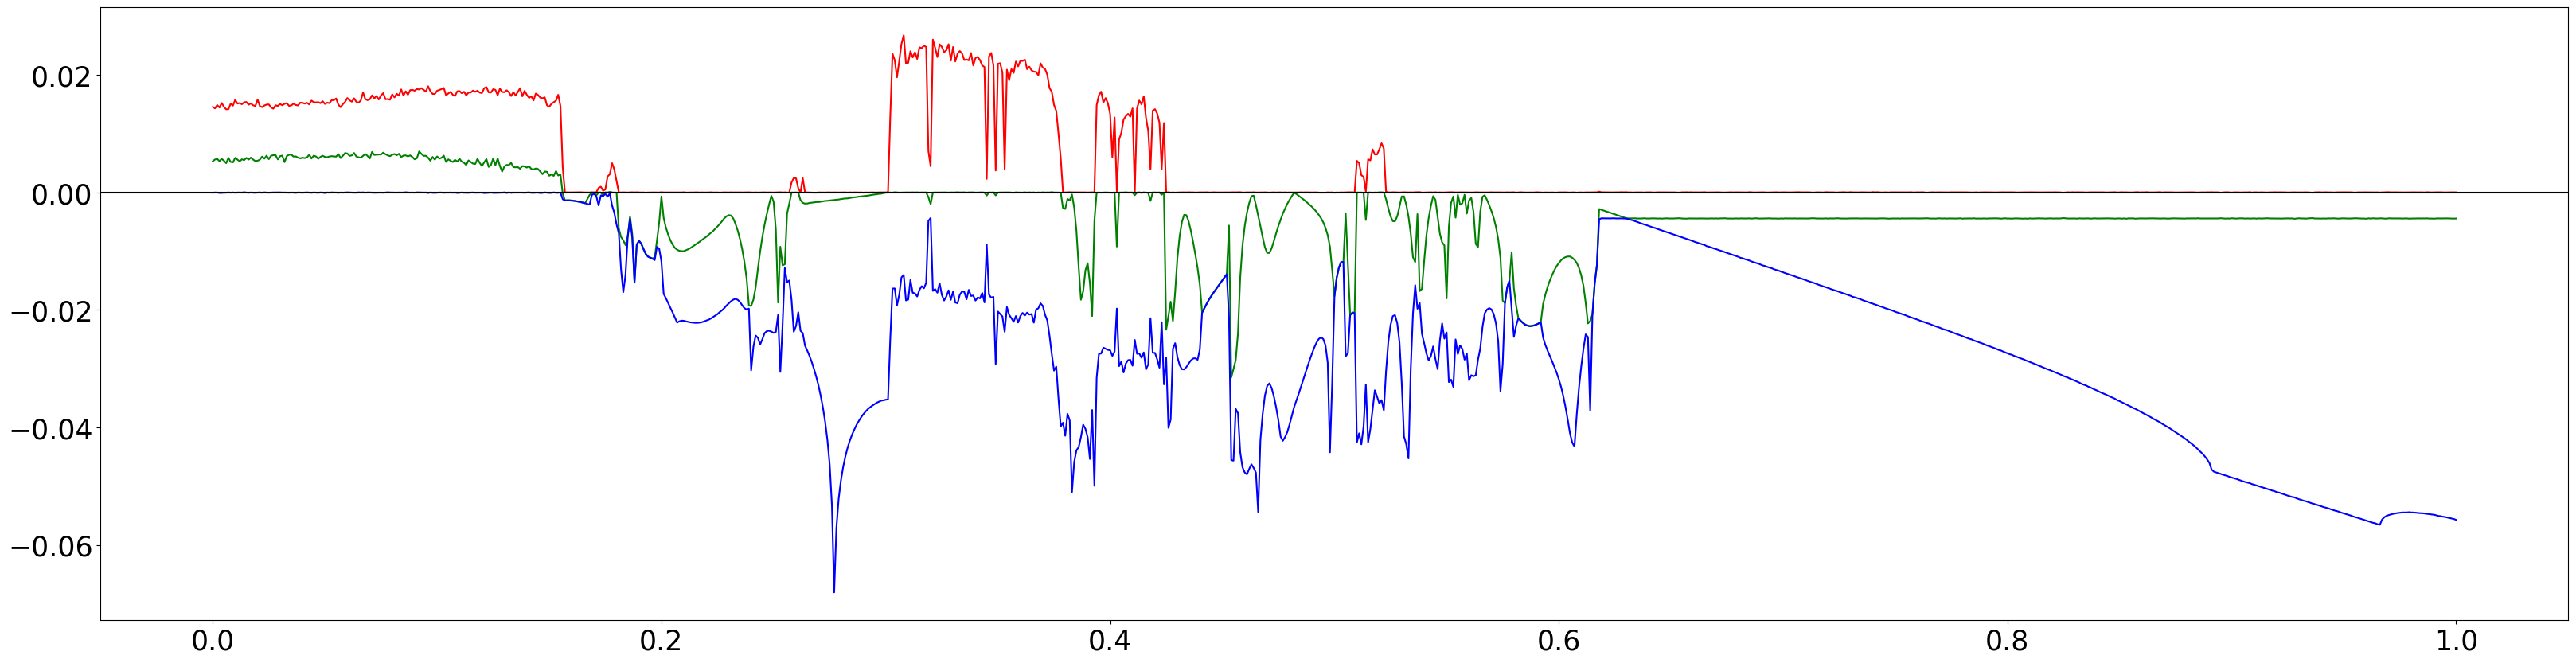

In [23]:
fig, ax = subplots(figsize = (40, 10))
ax.plot(k_space, spectrum_array[1, 1:end], color = "red")
ax.plot(k_space, spectrum_array[2, 1:end], color = "green")
ax.plot(k_space, spectrum_array[3, 1:end], color = "blue")
ax.axhline(0, color = "black")
ax.tick_params(labelsize = 25)

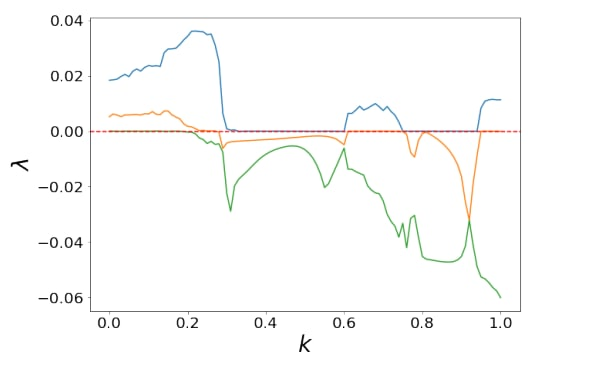

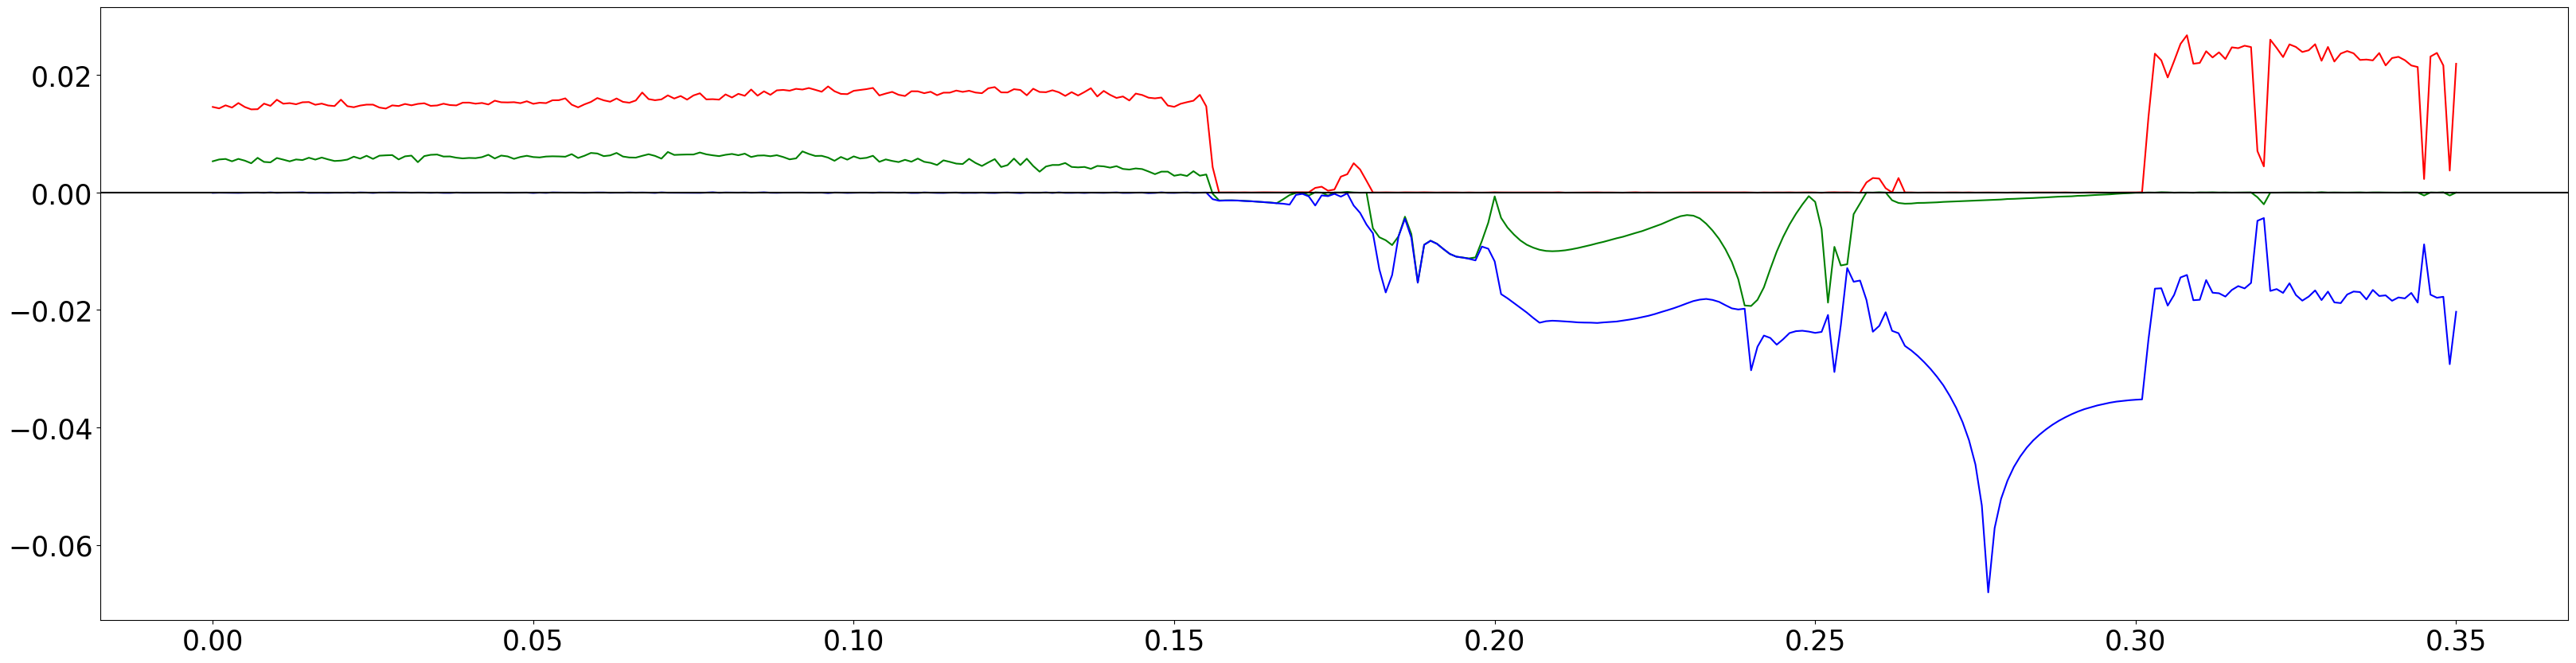

In [8]:
fig, ax = subplots(figsize = (40, 10))
ax.plot(k_space, spectrum_array[1, 1:end], color = "red")
ax.plot(k_space, spectrum_array[2, 1:end], color = "green")
ax.plot(k_space, spectrum_array[3, 1:end], color = "blue")
ax.axhline(0, color = "black")
ax.tick_params(labelsize = 25)

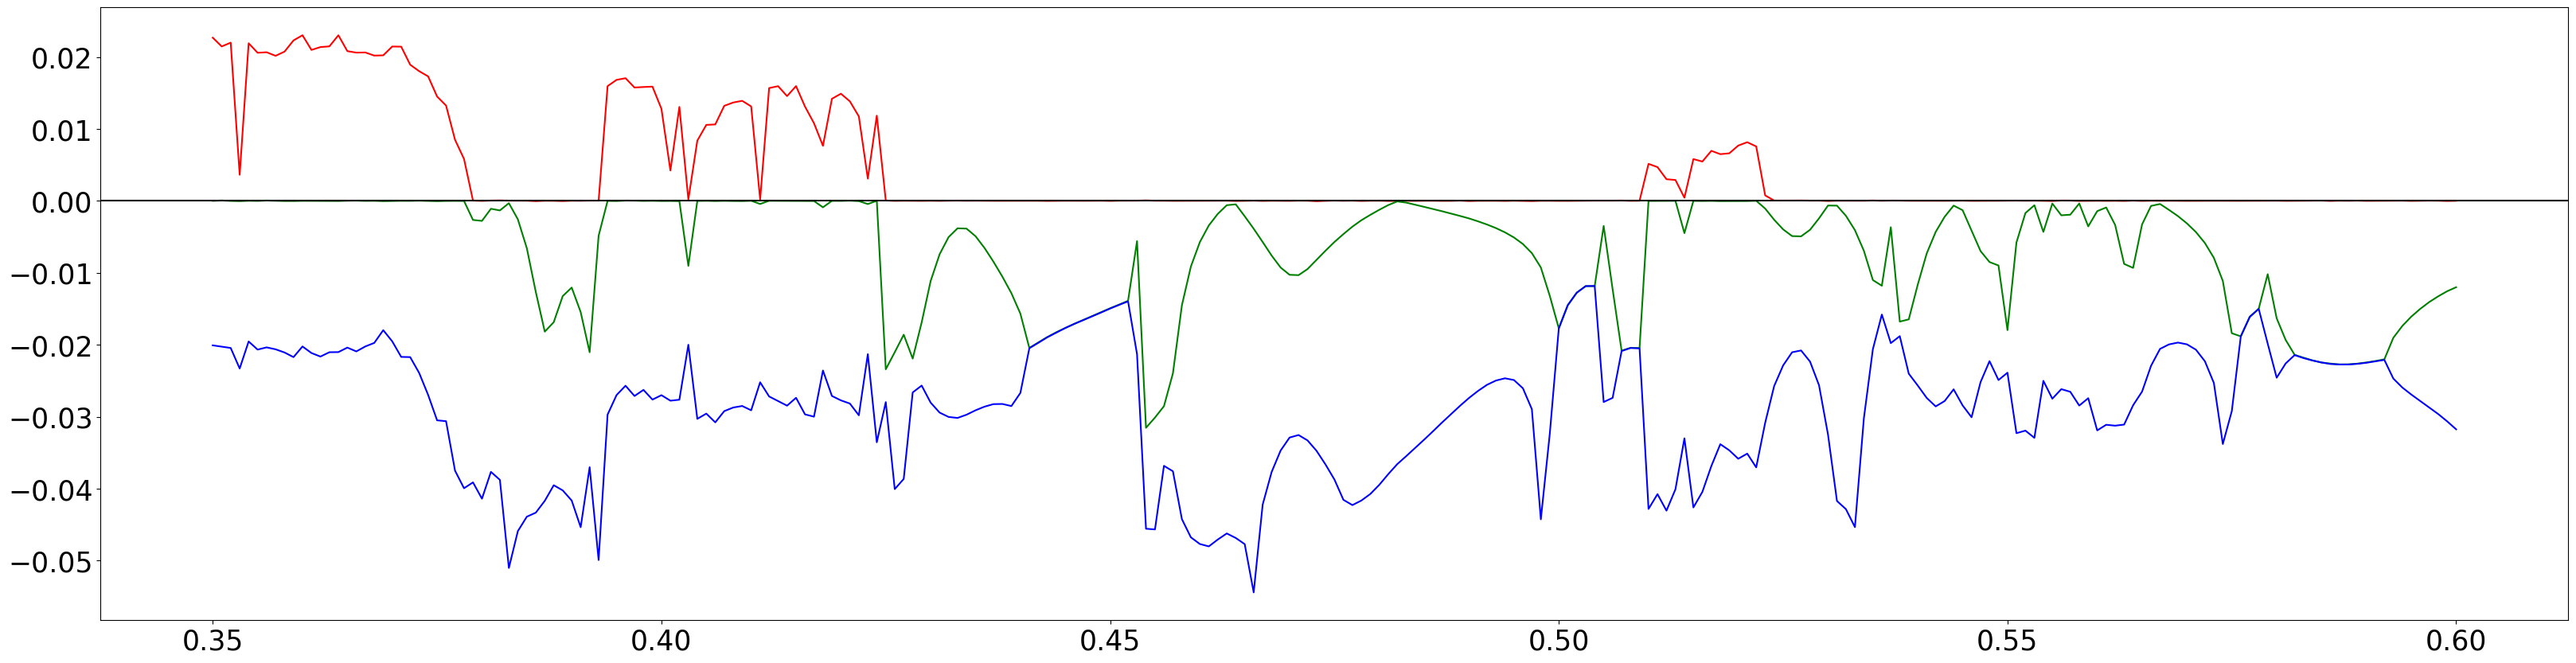

In [15]:
fig, ax = subplots(figsize = (40, 10))
ax.plot(k_space, spectrum_array[1, 1:end], color = "red")
ax.plot(k_space, spectrum_array[2, 1:end], color = "green")
ax.plot(k_space, spectrum_array[3, 1:end], color = "blue")
ax.axhline(0, color = "black")
ax.tick_params(labelsize = 25)

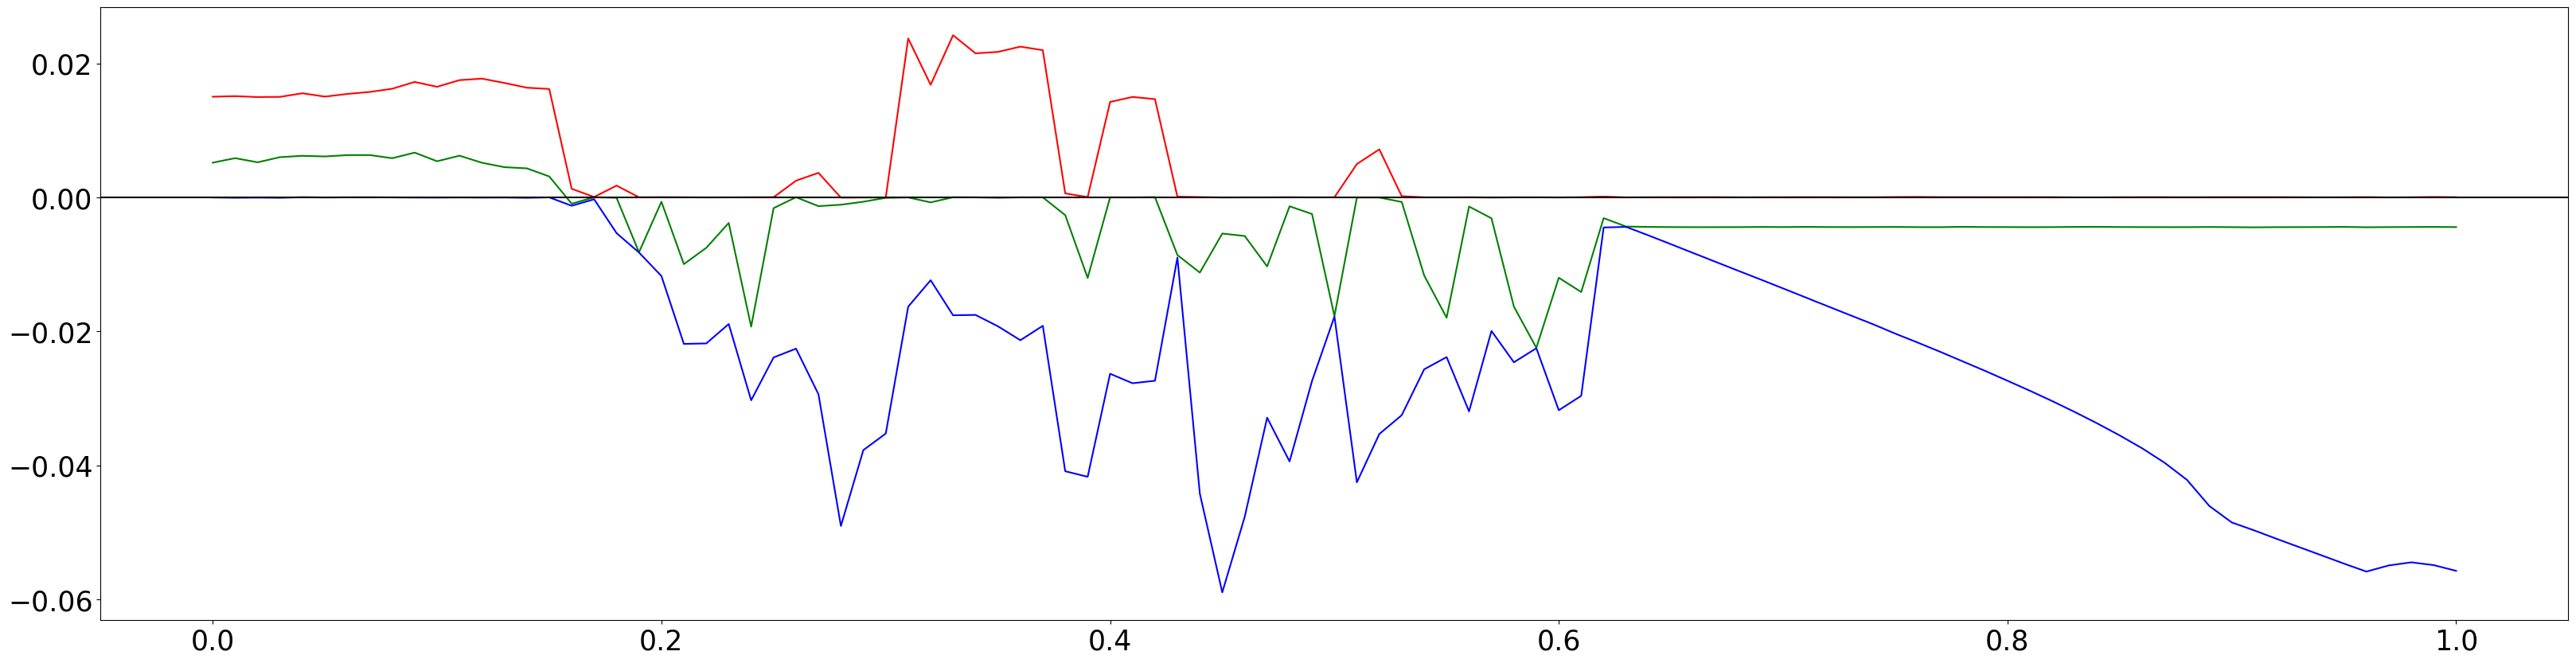

In [54]:
fig, ax = subplots(figsize = (40, 10))
ax.plot(k_space, spectrum_array[1, 1:end], color = "red")
ax.plot(k_space, spectrum_array[2, 1:end], color = "green")
ax.plot(k_space, spectrum_array[3, 1:end], color = "blue")
ax.axhline(0, color = "black")
ax.tick_params(labelsize = 25)

In [134]:
k_space = range(0, 1, step = 0.01)


spectrum_array = zeros(3, length(k_space))

int(x) = floor(Int, x)

int (generic function with 1 method)

In [135]:
for (i, k) in enumerate(k_space)
    if i == 1
        global initialcondition = [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0] # [0.1, 0.2, 0.3, 0.4, 0.05, 0.6]
    end
    println("Initial condition: $initialcondition"); flush(stdout)
    println("k: $k"); flush(stdout)
    
    p = [a, b, c, d,
        s, xr, r, I, xv, k1, k2, k]
    prob = ODEProblem(HR!, initialcondition, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR!, initialcondition, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11,  maxiters = 10000000)) # ; diffeq = (alg = Vern9(), maxiters = 10000000)
    spectrum_array[1:3, i] = spectrum[1:3]
    
    println("Spectrum: ", spectrum_array[1:3, i]); flush(stdout)
    
    initialcondition = sol[length(sol.u)]
    
    println("Last point: ", initialcondition); flush(stdout)
    
    println(">>>>>>>>>>>>>>>"); flush(stdout)
    println(""); flush(stdout)
    
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
k: 0.0
Spectrum: [0.01501083902559465, 0.005256923672768024, -5.548660271581746e-5]
Last point: [-1.0455288713228634, -4.4343288969915085, 3.986591892132088, -0.7391176649044078, -2.50776605630452, 3.41468348072505]
>>>>>>>>>>>>>>>

Initial condition: [-1.0455288713228634, -4.4343288969915085, 3.986591892132088, -0.7391176649044078, -2.50776605630452, 3.41468348072505]
k: 0.01
Spectrum: [0.014729274819528492, 0.0065103419391332315, -5.389643564862507e-6]
Last point: [1.1608144461654863, -0.5395646866685295, 3.9674683995573, -1.272281746069413, -6.806072503321676, 3.5979707169797557]
>>>>>>>>>>>>>>>

Initial condition: [1.1608144461654863, -0.5395646866685295, 3.9674683995573, -1.272281746069413, -6.806072503321676, 3.5979707169797557]
k: 0.02
Spectrum: [0.01591849797917007, 0.005447371798347048, 2.6960789322736125e-5]
Last point: [-1.1608327292167888, -5.857414840707, 3.7357890882203058, -1.2387418512253852, -6.5743988639868975, 3.937

>>>>>>>>>>>>>>>

Initial condition: [-0.5762055685838016, -0.8318607187646718, 4.136184540711338, -1.4568376816106472, -9.98957084202144, 3.60627185628771]
k: 0.22
Spectrum: [5.247671114341564e-5, -0.0075062455576020886, -0.021824411722675133]
Last point: [0.1639363772196588, 0.9389834524260183, 4.674805827576242, -0.7728017254718403, -2.5626466208725414, 3.3459567678268765]
>>>>>>>>>>>>>>>

Initial condition: [0.1639363772196588, 0.9389834524260183, 4.674805827576242, -0.7728017254718403, -2.5626466208725414, 3.3459567678268765]
k: 0.23
Spectrum: [8.288181602722033e-6, -0.0038910859192284905, -0.01883315808249104]
Last point: [-1.5848013683202935, -11.89160574055182, 3.5966610695231864, -0.2473688805988724, 0.8029167290957655, 4.755708847775504]
>>>>>>>>>>>>>>>

Initial condition: [-1.5848013683202935, -11.89160574055182, 3.5966610695231864, -0.2473688805988724, 0.8029167290957655, 4.755708847775504]
k: 0.24
Spectrum: [4.150882220625466e-5, -0.01931282162913235, -0.03011560618225598]


Last point: [-0.6451885400147926, -0.5219534870412406, 4.9130320666107075, -1.08126199539933, -4.195761283186987, 4.817013124434218]
>>>>>>>>>>>>>>>

Initial condition: [-0.6451885400147926, -0.5219534870412406, 4.9130320666107075, -1.08126199539933, -4.195761283186987, 4.817013124434218]
k: 0.44
Spectrum: [9.310899735295309e-5, -0.011205458820609497, -0.044274987165324534]
Last point: [-0.41644170593167457, -0.24668217731481135, 4.05367338766184, 0.06078313182137946, 0.7554274721243165, 4.188588899924037]
>>>>>>>>>>>>>>>

Initial condition: [-0.41644170593167457, -0.24668217731481135, 4.05367338766184, 0.06078313182137946, 0.7554274721243165, 4.188588899924037]
k: 0.45
Spectrum: [9.628761138989711e-6, -0.005416860525725967, -0.058934219432140805]
Last point: [-0.7501312628634446, -2.322684567256592, 3.7750757560761703, -0.5613338592586343, -1.09212413366452, 3.8368159525830623]
>>>>>>>>>>>>>>>

Initial condition: [-0.7501312628634446, -2.322684567256592, 3.7750757560761703, -0.5613338

k: 0.65
Spectrum: [4.004538711386196e-5, -0.004555447750067197, -0.006896953303216086]
Last point: [-0.8582526246088544, -2.7843389805906096, 4.042671563972109, -0.8582526246088544, -2.7843389805906096, 4.042671563972109]
>>>>>>>>>>>>>>>

Initial condition: [-0.8582526246088544, -2.7843389805906096, 4.042671563972109, -0.8582526246088544, -2.7843389805906096, 4.042671563972109]
k: 0.66
Spectrum: [6.899895817787766e-5, -0.004429660294988114, -0.00835313439345335]
Last point: [-1.2900320375973553, -7.453433645307931, 3.6740094489959305, -1.2900320375973553, -7.453433645307931, 3.6740094489959305]
>>>>>>>>>>>>>>>

Initial condition: [-1.2900320375973553, -7.453433645307931, 3.6740094489959305, -1.2900320375973553, -7.453433645307931, 3.6740094489959305]
k: 0.67
Spectrum: [4.948102857187049e-5, -0.004449746115025123, -0.009604140835855694]
Last point: [0.10569278478361663, 0.777874096736888, 4.111335919173583, 0.10569278478361663, 0.777874096736888, 4.111335919173583]
>>>>>>>>>>>>>>>

Init

k: 0.87
Spectrum: [7.526343156199643e-5, -0.004505101454701702, -0.039637704142416484]
Last point: [-0.5573115946075622, -0.9447948746336214, 4.060335991731306, -0.5573115946075622, -0.9447948746336214, 4.060335991731306]
>>>>>>>>>>>>>>>

Initial condition: [-0.5573115946075622, -0.9447948746336214, 4.060335991731306, -0.5573115946075622, -0.9447948746336214, 4.060335991731306]
k: 0.88
Spectrum: [7.602890635905073e-5, -0.004446883533151727, -0.04212196284569376]
Last point: [-1.1115145046062724, -5.514324507887811, 3.5320778792175185, -1.1115145046062724, -5.514324507887811, 3.5320778792175185]
>>>>>>>>>>>>>>>

Initial condition: [-1.1115145046062724, -5.514324507887811, 3.5320778792175185, -1.1115145046062724, -5.514324507887811, 3.5320778792175185]
k: 0.89
Spectrum: [0.00011970454291606197, -0.004436791847342237, -0.04602066763818843]
Last point: [-0.9454434584248003, -3.303341543025325, 4.241489227304141, -0.9454434584248003, -3.303341543025325, 4.241489227304141]
>>>>>>>>>>>>>>>

I

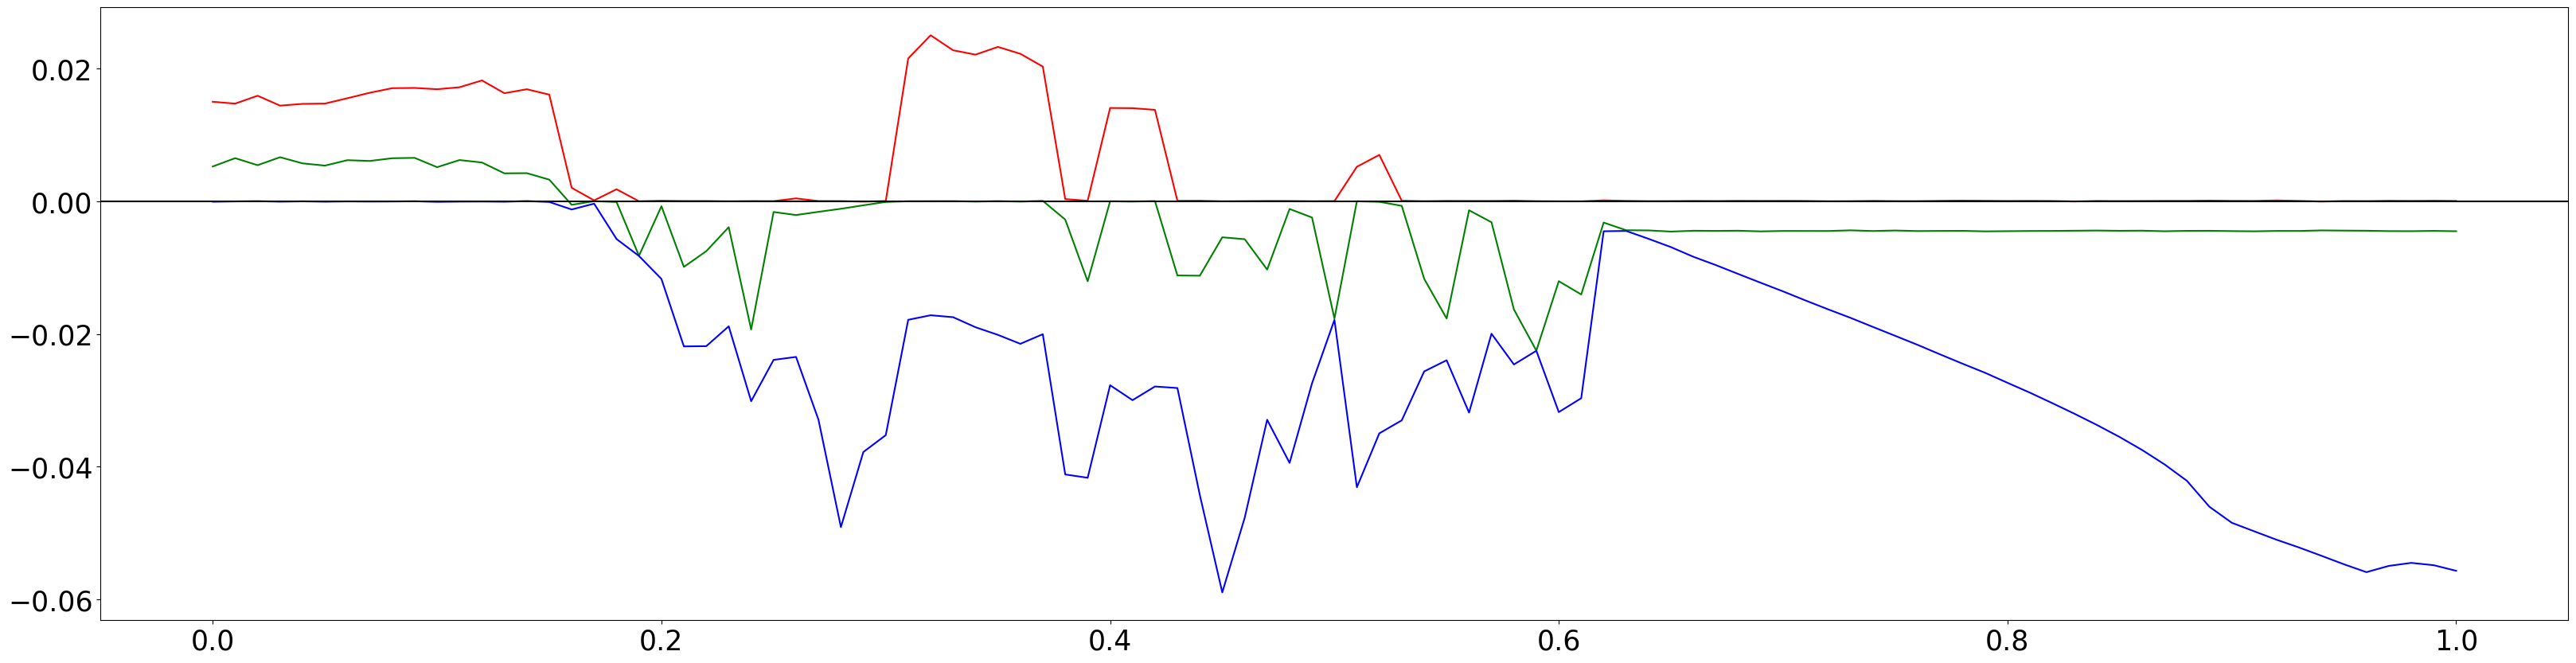

In [136]:
fig, ax = subplots(figsize = (40, 10))
st = 1

ax.plot(k_space[st:end], spectrum_array[1, st:end], color = "red")
ax.plot(k_space[st:end], spectrum_array[2, st:end], color = "green")
ax.plot(k_space[st:end], spectrum_array[3, st:end], color = "blue")
ax.axhline(0, color = "black")
ax.tick_params(labelsize = 25)

In [169]:
filename = "$(lpad(1, 4, "0")).png"
directory = "C:\\Users\\olenin.s\\Desktop\\res_HR_full_small\\"
directory = directory * filename

"C:\\Users\\olenin.s\\Desktop\\res_HR_full_small\\0001.png"

In [186]:
for i in range(1, 1001)
    mv("$i.png", "$(lpad(i, 5, "0")).png")
end

In [213]:
using FFMPEG
imagesdirectory = pwd()

"C:\\Users\\olenin.s\\Desktop\\test"

In [226]:
framerate = 10
gifname = "\\output.gif"
gifname = imagesdirectory * gifname

"C:\\Users\\olenin.s\\Desktop\\test\\output.gif"

In [ ]:
FFMPEG.ffmpeg_exe(`-framerate $(framerate) -f image2 -i $(imagesdirectory)/%5d.png -y $(gifname)`)

In [227]:
FFMPEG.ffmpeg_exe(`-framerate $(framerate) -f image2 -i $(imagesdirectory)/%5d.png -vf "scale=1200:900" -c:v libx264 -pix_fmt yuv420p -y "C:\\Users\\olenin.s\\Desktop\\test\\output-video.mov"`)

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 8.1.0 (GCC)
  configuration: --enable-cross-compile --cross-prefix=/opt/x86_64-w64-mingw32/bin/x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw64 --cc=cc --cxx=c++ --dep-cc=cc --ar=ar --nm=nm --sysinclude=/workspace/destdir/include --pkg-config=/usr/bin/pkg-config --pkg-config-flags=--static --prefix=/workspace/destdir --sysroot=/opt/x86_64-w64-mingw32/x86_64-w64-mingw32/sys-root --extra-libs=-lpthread --enable-gpl --enable-version3 --enable-nonfree --disable-static --enable-shared --enable-pic --disable-debug --disable-doc --enable-avresample --enable-libass --enable-libfdk-aac --enable-libfreetype --enable-libmp3lame --enable-libopus --enable-libvorbis --enable-libx264 --enable-libx265 --enable-libvpx --enable-encoders --enable-decoders --enable-muxers --enable-demuxers --enable-parsers --enable-openssl --disable-schannel --extra-cflags=-I/workspace/destdir/include --extra-ldflags=-L/workspace/destdi

Process(`'C:\Users\olenin.s\.julia\artifacts\ecb81e6429c089c1da802644fae337754832d534\bin\ffmpeg.exe' -framerate 10 -f image2 -i 'C:\Users\olenin.s\Desktop\test/%5d.png' -vf scale=1200:900 -c:v libx264 -pix_fmt yuv420p -y 'C:\Users\olenin.s\Desktop\test\output-video.mov'`, ProcessExited(0))

In [229]:
filename = "$(lpad(1, 4, "0")).png"
directory = "C:\\Users\\olenin.s\\Desktop\\res_HR_full_small\\"
directory = directory * filename

fig.savefig(directory)